In [2]:
# !rm gen_image.tar.gz
# !wget http://mireu-server.iptime.org/api/public/dl/QLwEhRq3/DataSet/%EA%B0%9D%EC%B2%B4%EC%9D%B8%EC%8B%9D_%EC%97%B0%EA%B5%AC/13.%ED%95%9C%EA%B5%AD%EC%96%B4%EA%B8%80%EC%9E%90%EC%B2%B4/image_gen/new_image/gen_image.tar.gz
# !tar -xzvf gen_image.tar.gz
# !pip3 install tqdm

In [4]:
from PIL import Image
import numpy as np
import os

layerList = ["가", "나", "다"]
# , "라", "마", "바", "아", "자", "차", "카", "타", "파", "하"

all_x_array = []
all_y_array = []

for dir in layerList:
    fileList = os.listdir(f"./gen_image/{dir}")[:14000]

    for file in fileList:
        y_array = dict.fromkeys(layerList, 0) # 12000개의 str 값을 0으로 초기화하는 dict 생성

        imageData = Image.open(f"""./gen_image/{dir}/{file}""") # 이미지 tensor 데이터 출력
        imageData = imageData.resize((50, 50)) # 이미지 다운스케일링

        imageData = np.array(imageData)
        all_x_array.append(imageData.tolist())

        y_array[dir] = 1 # 사용자가 지정한 str 값을 1로 변경
        y_array = list(y_array.values())
        all_y_array.append(y_array)


In [5]:
import numpy as np

x_array = np.array(all_x_array)
y_array = np.array(all_y_array)

In [6]:
del all_x_array, all_y_array

In [7]:
print(x_array.shape, y_array.shape)

(42000, 50, 50, 3) (42000, 3)


In [8]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, Y_train, Y_test = train_test_split(
#     x_array, y_array, test_size=0.4, shuffle=False, random_state=1004
# )

from sklearn.model_selection import KFold

# split 개수, 셔플 여부 및 seed 설정
kf = KFold(n_splits = 10, shuffle = True, random_state = 50)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in kf.split(x_array):
    X_train, X_test = x_array[train_index], x_array[test_index]
    Y_train, Y_test = y_array[train_index], y_array[test_index]

In [9]:
X_train = X_train.astype("float32") / 255
Y_train = Y_train.astype("float32") / 255

X_test = X_test.astype("float32") / 255
Y_test = Y_test.astype("float32") / 255

In [10]:
image_w, image_h, image_layer = X_train.shape[1], X_train.shape[2], X_train.shape[3]

X_train = X_train.reshape(-1, image_w, image_h, image_layer)
X_test = X_test.reshape(-1, image_w, image_h, image_layer)

In [11]:
DataSet_classes = Y_train.shape[1]

In [12]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(37800, 50, 50, 3) (4200, 50, 50, 3)
(37800, 3) (4200, 3)


In [13]:
import tensorflow as tf

# tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus: # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')

  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

2024-03-14 02:25:48.613553: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 02:25:48.843740: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 02:25:48.843957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 02:25:48.886498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 02:25:48.977056: I tensorflow/core/platform/cpu_feature_guar

In [14]:
import tensorflow as tf

model = tf.keras.applications.MobileNetV2(
    include_top=True,
    weights=None,
    input_shape=(image_w, image_h, image_layer),
    pooling=None,
    classes=DataSet_classes,
    classifier_activation="softmax",
)


2024-03-14 02:25:50.664431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4065 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [15]:
model.summary()

Model: "mobilenetv2_1.00_50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 25, 25, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 25, 25, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 25, 25, 32)           0         ['bn_Conv1[0

In [16]:
import tensorflow as tf

batch_size = 64
epochs = 50

model.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy"]
)

history = model.fit(
    X_train, Y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(X_test, Y_test)
)

Epoch 1/50


2024-03-14 02:25:58.412639: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-14 02:25:58.579432: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-14 02:26:00.056147: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc4c904b0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 02:26:00.056175: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-03-14 02:26:00.069301: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-14 02:26:00.135603: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
I0000 00:00:1710350760.177858    6979 devic

591/591 [==============================] - 39s 38ms/step - loss: 0.0043 - accuracy: 0.3337 - val_loss: 0.0043 - val_accuracy: 0.3319
Epoch 2/50
591/591 [==============================] - 19s 32ms/step - loss: 0.0043 - accuracy: 0.3348 - val_loss: 0.0044 - val_accuracy: 0.3319
Epoch 3/50
591/591 [==============================] - 19s 32ms/step - loss: 0.0043 - accuracy: 0.3344 - val_loss: 0.0043 - val_accuracy: 0.3267
Epoch 4/50
591/591 [==============================] - 19s 32ms/step - loss: 0.0043 - accuracy: 0.3341 - val_loss: 0.0043 - val_accuracy: 0.3414
Epoch 5/50
591/591 [==============================] - 19s 32ms/step - loss: 0.0043 - accuracy: 0.3341 - val_loss: 0.0043 - val_accuracy: 0.3319
Epoch 6/50
591/591 [==============================] - 19s 32ms/step - loss: 0.0043 - accuracy: 0.3341 - val_loss: 0.0043 - val_accuracy: 0.3319
Epoch 7/50
591/591 [==============================] - 19s 32ms/step - loss: 0.0043 - accuracy: 0.3341 - val_loss: 0.0043 - val_accuracy: 0.3319
Epo

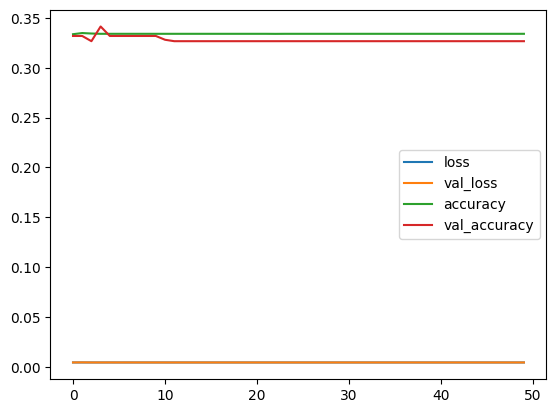

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [18]:
model.save('../../model/MobileNetV2.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
